In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Load and prepare data
data = pd.read_csv("/content/car_data2.csv")
data = data.apply(lambda x: LabelEncoder().fit_transform(x.astype(str)) if x.dtype == type(object) else x)
data.fillna(data.median(), inplace=True)
data.drop('policy_id', axis=1, inplace=True, errors='ignore')

# Prepare features and target
X = data.drop('claim_status', axis=1)
y = LabelEncoder().fit_transform(data['claim_status']) if data['claim_status'].dtype == type(object) else data['claim_status']

# Handle class imbalance
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# Configure and train Random Forest with pruning parameters
param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None],  # Adding different depths
    'min_samples_split': [2, 10, 20],  # Adding min_samples_split parameter
    'min_samples_leaf': [1, 5, 10],  # Adding min_samples_leaf parameter
    'criterion': ['gini']
}

# Enable parallelization by setting n_jobs=-1
best_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train).best_estimator_

# Evaluate model
y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate observed and expected counts
observed_counts = np.bincount(y_pred)
expected_counts = np.array([len(y_pred) / 2, len(y_pred) / 2])  # Assuming two classes and p=0.5 for each

# Construct contingency table
contingency_table = np.array([observed_counts, expected_counts])

# Perform Chi-squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table, correction=False)
print("Chi-squared Test Statistic:", chi2)
print("P-value:", p_value)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89     22024
           1       0.88      0.89      0.89     21852

    accuracy                           0.89     43876
   macro avg       0.89      0.89      0.89     43876
weighted avg       0.89      0.89      0.89     43876

Chi-squared Test Statistic: 1.1669404883306906
P-value: 0.280030780711578


The goal of our project is to predict is a car insurance claim is apporved or denied.

Variables:

Qualitative:  
    'region_code', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
    'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type',
    'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
    'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
    'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert'

Quantitative:
    'subscription_length', 'vehicle_age', 'customer_age', 'region_density',
    'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
    'gross_weight', 'ncap_rating'

:We want to run a random forests classifier that predicts if the insurance claim is approved or denied. We use SMOTE to generate synthetic samples because of the class imbalance and we use a gridsearch to find the best hyperparameters that produce the highest accuracy.

Neural Network's are also a good way to do prediction. Here we use Tensorflow to process the parameters and create the neural network. Then we add new layers and try to improve out performance. The most I got was 69% accuracy which is much less than the random forest model.

Neural Network ROC-AUC curves

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 5s 3ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 5s 3ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 5s 3ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 4s 2ms/step

1831/1831 [==============================] - 5s 3ms/step

1831/1831 [==============================] - 5s 2ms/step

1831/1831 [==============================] - 5s 3ms/step

1831/1831 [===

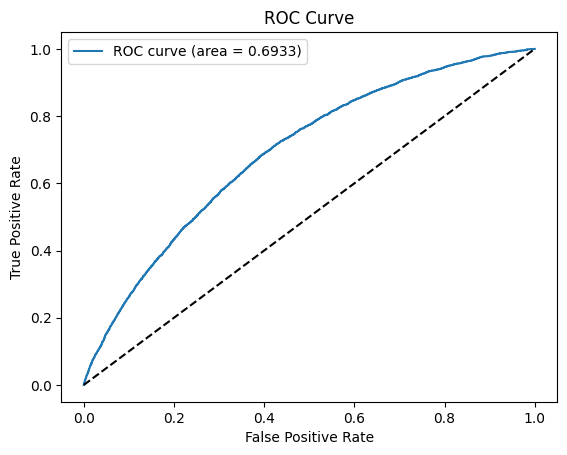

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
file_path = '/content/car_data2.csv'

# Define a preprocessing pipeline
numeric_features = [
    'subscription_length', 'vehicle_age', 'customer_age', 'region_density',
    'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
    'gross_weight', 'ncap_rating'
]
categorical_features = [
    'region_code', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
    'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type',
    'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
    'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
    'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Load the entire dataset to preprocess and perform the grid search
data = pd.read_csv(file_path)
data = data.drop(columns=['policy_id'])

# Split the data into features and target
features = data.drop(columns=['claim_status'])
labels = data['claim_status']

# Preprocess the features
features = preprocessor.fit_transform(features)
input_shape = features.shape[1]

# Define the model creation function
def create_model(params):
    model = Sequential([
        Dense(int(params['neurons']), activation=params['activation'], input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']//2), activation=params['activation']),
        BatchNormalization(),
        Dropout(params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the objective function for Hyperopt
def objective(params):
    model = create_model(params)
    history = model.fit(features, labels, epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0)
    val_predictions = model.predict(features)
    roc_auc = roc_auc_score(labels, val_predictions)
    return {'loss': -roc_auc, 'status': STATUS_OK, 'model': model}

# Define the hyperparameter space
space = {
    'neurons': hp.quniform('neurons', 64, 256, 1),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),
    'batch_size': hp.quniform('batch_size', 32, 128, 1),
    'epochs': hp.quniform('epochs', 10, 50, 1)
}

# Run the hyperparameter optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

# Get the best model from the trials
best_model = None
for trial in trials.trials:
    if trial['result']['status'] == STATUS_OK:
        if best_model is None or trial['result']['loss'] < best_model['result']['loss']:
            best_model = trial

# Predict probabilities using the best model
best_keras_model = best_model['result']['model']
predictions = best_keras_model.predict(features)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(labels, predictions)
print(f"Best Hyperparameters: {best}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Save the best model
best_keras_model.save('best_car_claim_model.h5')


Another layer

Epoch 1/42
690/690 [==============================] - 8s 8ms/step - loss: 0.6768 - accuracy: 0.9041 - val_loss: 0.3513 - val_accuracy: 0.9328
Epoch 2/42
690/690 [==============================] - 7s 11ms/step - loss: 0.6707 - accuracy: 0.9090 - val_loss: 0.3669 - val_accuracy: 0.8970
Epoch 3/42
690/690 [==============================] - 4s 6ms/step - loss: 0.6708 - accuracy: 0.9088 - val_loss: 0.3748 - val_accuracy: 0.8950
Epoch 4/42
690/690 [==============================] - 4s 5ms/step - loss: 0.6716 - accuracy: 0.9073 - val_loss: 0.3755 - val_accuracy: 0.8979
Epoch 5/42
690/690 [==============================] - 4s 6ms/step - loss: 0.6705 - accuracy: 0.9092 - val_loss: 0.3680 - val_accuracy: 0.9001
Epoch 6/42
690/690 [==============================] - 4s 6ms/step - loss: 0.6725 - accuracy: 0.9111 - val_loss: 0.3587 - val_accuracy: 0.9020
Epoch 7/42
690/690 [==============================] - 4s 5ms/step - loss: 0.6728 - accuracy: 0.9088 - val_loss: 0.3451 - val_accuracy: 0.9129
Epoch

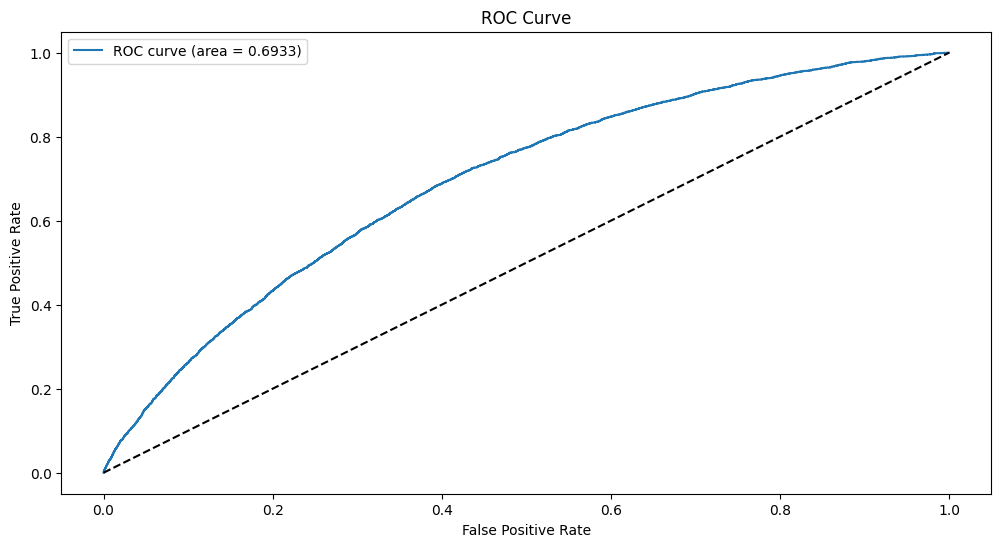

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/car_data2.csv'

# Define a preprocessing pipeline
numeric_features = [
    'subscription_length', 'vehicle_age', 'customer_age', 'region_density',
    'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
    'gross_weight', 'ncap_rating'
]
categorical_features = [
    'region_code', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
    'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type',
    'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
    'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
    'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Load the entire dataset to preprocess
data = pd.read_csv(file_path)
data = data.drop(columns=['policy_id'])

# Split the data into features and target
features = data.drop(columns=['claim_status'])
labels = data['claim_status']

# Preprocess the features
features = preprocessor.fit_transform(features)
input_shape = features.shape[1]

# Load the pre-trained model
pretrained_model = load_model('best_car_claim_model.h5')

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the new model using the best optimizer found
optimizer_choice = 'adam' if 0 == 0 else 'rmsprop'  # adjust based on your optimizer choice
model.compile(optimizer=optimizer_choice, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define class weights to address class imbalance (adjust these weights according to your class distribution)
class_weights = {0: 1.0, 1: 5.0}  # Example weights, adjust based on your data

# Train the new model
history = model.fit(features, labels, epochs=42, batch_size=68, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the new model
val_predictions = model.predict(features)
roc_auc = roc_auc_score(labels, val_predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, val_predictions)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Save the new model in the recommended Keras format
model.save('fine_tuned_car_claim_model.keras')


Another Layer

Epoch 1/30
1465/1465 [==============================] - 14s 6ms/step - loss: 0.8436 - accuracy: 0.6902 - val_loss: 0.6336 - val_accuracy: 0.7299
Epoch 2/30
1465/1465 [==============================] - 11s 8ms/step - loss: 0.8021 - accuracy: 0.7911 - val_loss: 0.5806 - val_accuracy: 0.8281
Epoch 3/30
1465/1465 [==============================] - 11s 7ms/step - loss: 0.7691 - accuracy: 0.8399 - val_loss: 0.5309 - val_accuracy: 0.8676
Epoch 4/30
1465/1465 [==============================] - 10s 7ms/step - loss: 0.7407 - accuracy: 0.8644 - val_loss: 0.4889 - val_accuracy: 0.8892
Epoch 5/30
1465/1465 [==============================] - 13s 9ms/step - loss: 0.7201 - accuracy: 0.8824 - val_loss: 0.4553 - val_accuracy: 0.9022
Epoch 6/30
1465/1465 [==============================] - 11s 7ms/step - loss: 0.7051 - accuracy: 0.8926 - val_loss: 0.4277 - val_accuracy: 0.9112
Epoch 7/30
1465/1465 [==============================] - 11s 8ms/step - loss: 0.6956 - accuracy: 0.8973 - val_loss: 0.4078 - val_ac

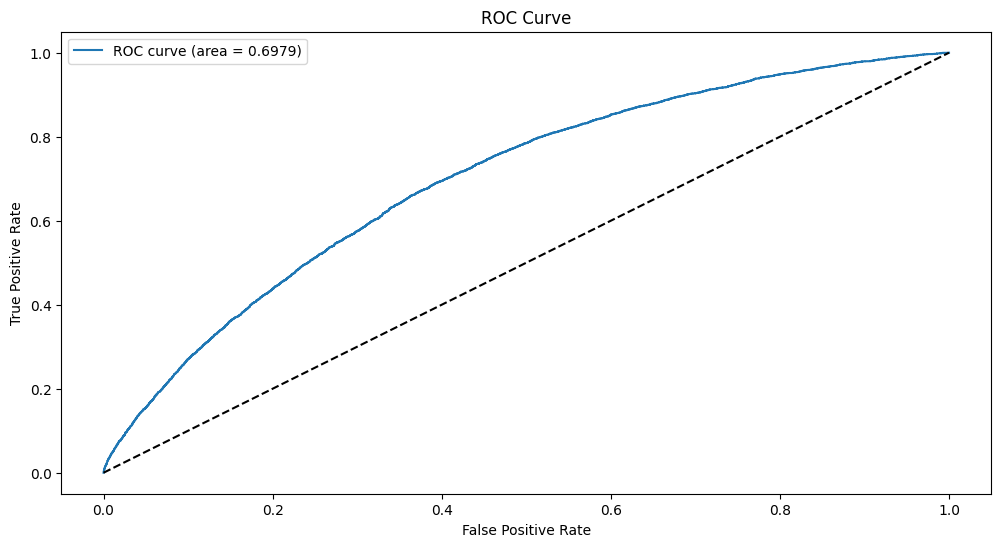

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/car_data2.csv'

# Define a preprocessing pipeline
numeric_features = [
    'subscription_length', 'vehicle_age', 'customer_age', 'region_density',
    'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
    'gross_weight', 'ncap_rating'
]
categorical_features = [
    'region_code', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
    'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type',
    'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
    'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
    'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Load the entire dataset to preprocess
data = pd.read_csv(file_path)
data = data.drop(columns=['policy_id'])

# Split the data into features and target
features = data.drop(columns=['claim_status'])
labels = data['claim_status']

# Preprocess the features
features = preprocessor.fit_transform(features)
input_shape = features.shape[1]

# Load the previously trained model
pretrained_model = load_model('/content/fine_tuned_car_claim_model.keras')

# Unfreeze some layers for fine-tuning
for layer in pretrained_model.layers[-5:]:  # Unfreezing the last 5 layers as an example
    layer.trainable = True

# Add more layers to the model
x = pretrained_model.output
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the new model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define class weights to address class imbalance (adjust these weights according to your class distribution)
class_weights = {0: 1.0, 1: 5.0}  # Example weights, adjust based on your data

# Train the model
history = model.fit(features, labels, epochs=30, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model
val_predictions = model.predict(features)
roc_auc = roc_auc_score(labels, val_predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, val_predictions)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Save the refined model
model.save('refined_car_claim_model.keras')


In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

# Load the dataset
file_path = '/content/car_data2.csv'

# Define a preprocessing pipeline
numeric_features = [
    'subscription_length', 'vehicle_age', 'customer_age', 'region_density',
    'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
    'gross_weight', 'ncap_rating'
]
categorical_features = [
    'region_code', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
    'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type',
    'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
    'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
    'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Load and preprocess the dataset
data = pd.read_csv(file_path)
data = data.drop(columns=['policy_id'])

features = data.drop(columns=['claim_status'])
labels = data['claim_status']

features = preprocessor.fit_transform(features)
input_shape = features.shape[1]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
features, labels = smote.fit_resample(features, labels)

# Load the pre-trained model
pretrained_model = load_model('refined_car_claim_model.keras')

# Unfreeze some layers for fine-tuning
for layer in pretrained_model.layers[-5:]:
    layer.trainable = True

# Add more layers to the model
x = pretrained_model.output
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Define the model creation function for KerasTuner
def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    x = pretrained_model.output
    x = Dense(units=hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=pretrained_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Stop early if validation accuracy does not improve
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter tuning
tuner.search(features, labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
history = model.fit(features, labels, epochs=50, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
val_predictions = model.predict(features)
roc_auc = roc_auc_score(labels, val_predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, val_predictions)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Save the refined model
model.save('refined2_car_claim_model.keras')

ModuleNotFoundError: No module named 'keras_tuner'